In [1]:
import chipwhisperer as cw
import numpy as np
import scienceplots
import matplotlib.pyplot as plt

import simon_64_128_simulation
import correlations

from helper import KeyHypothesis
from measurement import Measurements

/home/nico/miniconda3/envs/simon/lib/python3.13/site-packages/chipwhisperer/capture/trace/TraceWhisperer.py:31: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources # type: ignore


# Import Trace

In [2]:
project = cw.import_project("./traces/07_simon_plain_50000/trace.zip", overwrite=True)
# project = cw.import_project("./traces/10_simon_masked_50000/trace.zip", overwrite=True)
# project = cw.import_project("./traces/12_simon_masked_50000/trace.zip", overwrite=True)

In [3]:
TOTAL_NUM_MEASUREMENTS = len(project.traces)
TOTAL_VALS_PER_MEASUREMENT = len(project.traces[0].wave)

# Only use a subset
NUM_MEASUREMENTS = 5000
VALS_PER_MEASUREMENT = 800

# Transform Trace Project into Measurement object

In [4]:
plaintexts = np.zeros((TOTAL_NUM_MEASUREMENTS, 2), dtype=np.uint32)
ciphertexts = np.zeros((TOTAL_NUM_MEASUREMENTS, 2), dtype=np.uint32)
powers = np.zeros((TOTAL_NUM_MEASUREMENTS, TOTAL_VALS_PER_MEASUREMENT), dtype=np.uint32)

for i, trace in enumerate(project.traces):

    pt = trace.textin
    ct = trace.textout

    plaintexts[i,0] = pt[0] << 24 | pt[1] << 16 | pt[2] << 8 | pt[3]
    plaintexts[i,1] = pt[4] << 24 | pt[5] << 16 | pt[6] << 8 | pt[7]

    ciphertexts[i,0] = ct[0] << 24 | ct[1] << 16 | ct[2] << 8 | ct[3]
    ciphertexts[i,1] = ct[4] << 24 | ct[5] << 16 | ct[6] << 8 | ct[7]
    powers[i,:] = trace.wave

measurements = Measurements(plaintexts[0:NUM_MEASUREMENTS], ciphertexts[0:NUM_MEASUREMENTS], powers[0:NUM_MEASUREMENTS, 0:VALS_PER_MEASUREMENT])

In [5]:
key = np.array([0x8dcc04b1, 0xad004534, 0x8afa7151, 0xf173d6d7], dtype=np.uint32)

# start with empty key as hypothesis as root for the search tree
empty_key = np.zeros((4,), dtype=np.uint32)
empty_mask = np.zeros((4,), dtype=np.uint32)
start_hypo = KeyHypothesis(empty_key, empty_mask)

KEY_MASK = np.array([0,0,0,0b00010000001000100100010010001001], dtype=np.uint32)


# guess 8 bits with a distance of 7
hypos = start_hypo.get_sub_hypos(KEY_MASK)
guessed_keys = np.array([h.key for h in hypos], dtype=np.uint32)

STATE_MASK = (KEY_MASK[3] << 1) & (KEY_MASK[3] << 8)
expected_hws = simon_64_128_simulation.get_hws_for_guessed_keys(
        measurements.plaintext,
        guessed_keys, 
        0, 
        STATE_MASK,
        "AND_GATE")
print(expected_hws.shape)

corrs = correlations.Corr((256,VALS_PER_MEASUREMENT))

# Number of measurements to include into correlcation calculation at once
n = 10

# Interval for displaying correlations in diagram
di = 50
best_corrs_over_num_measurements = np.zeros((256,NUM_MEASUREMENTS//di), dtype=np.float64)

for i in range(0,NUM_MEASUREMENTS, n):
    corrs.update(expected_hws[i:i+n,:], measurements.power[i:i+n,:]) 
    if i % di == 0:
        idx = i // di
        best_corrs_over_num_measurements[:, idx] = corrs.max(axis=1)


(5000, 256)


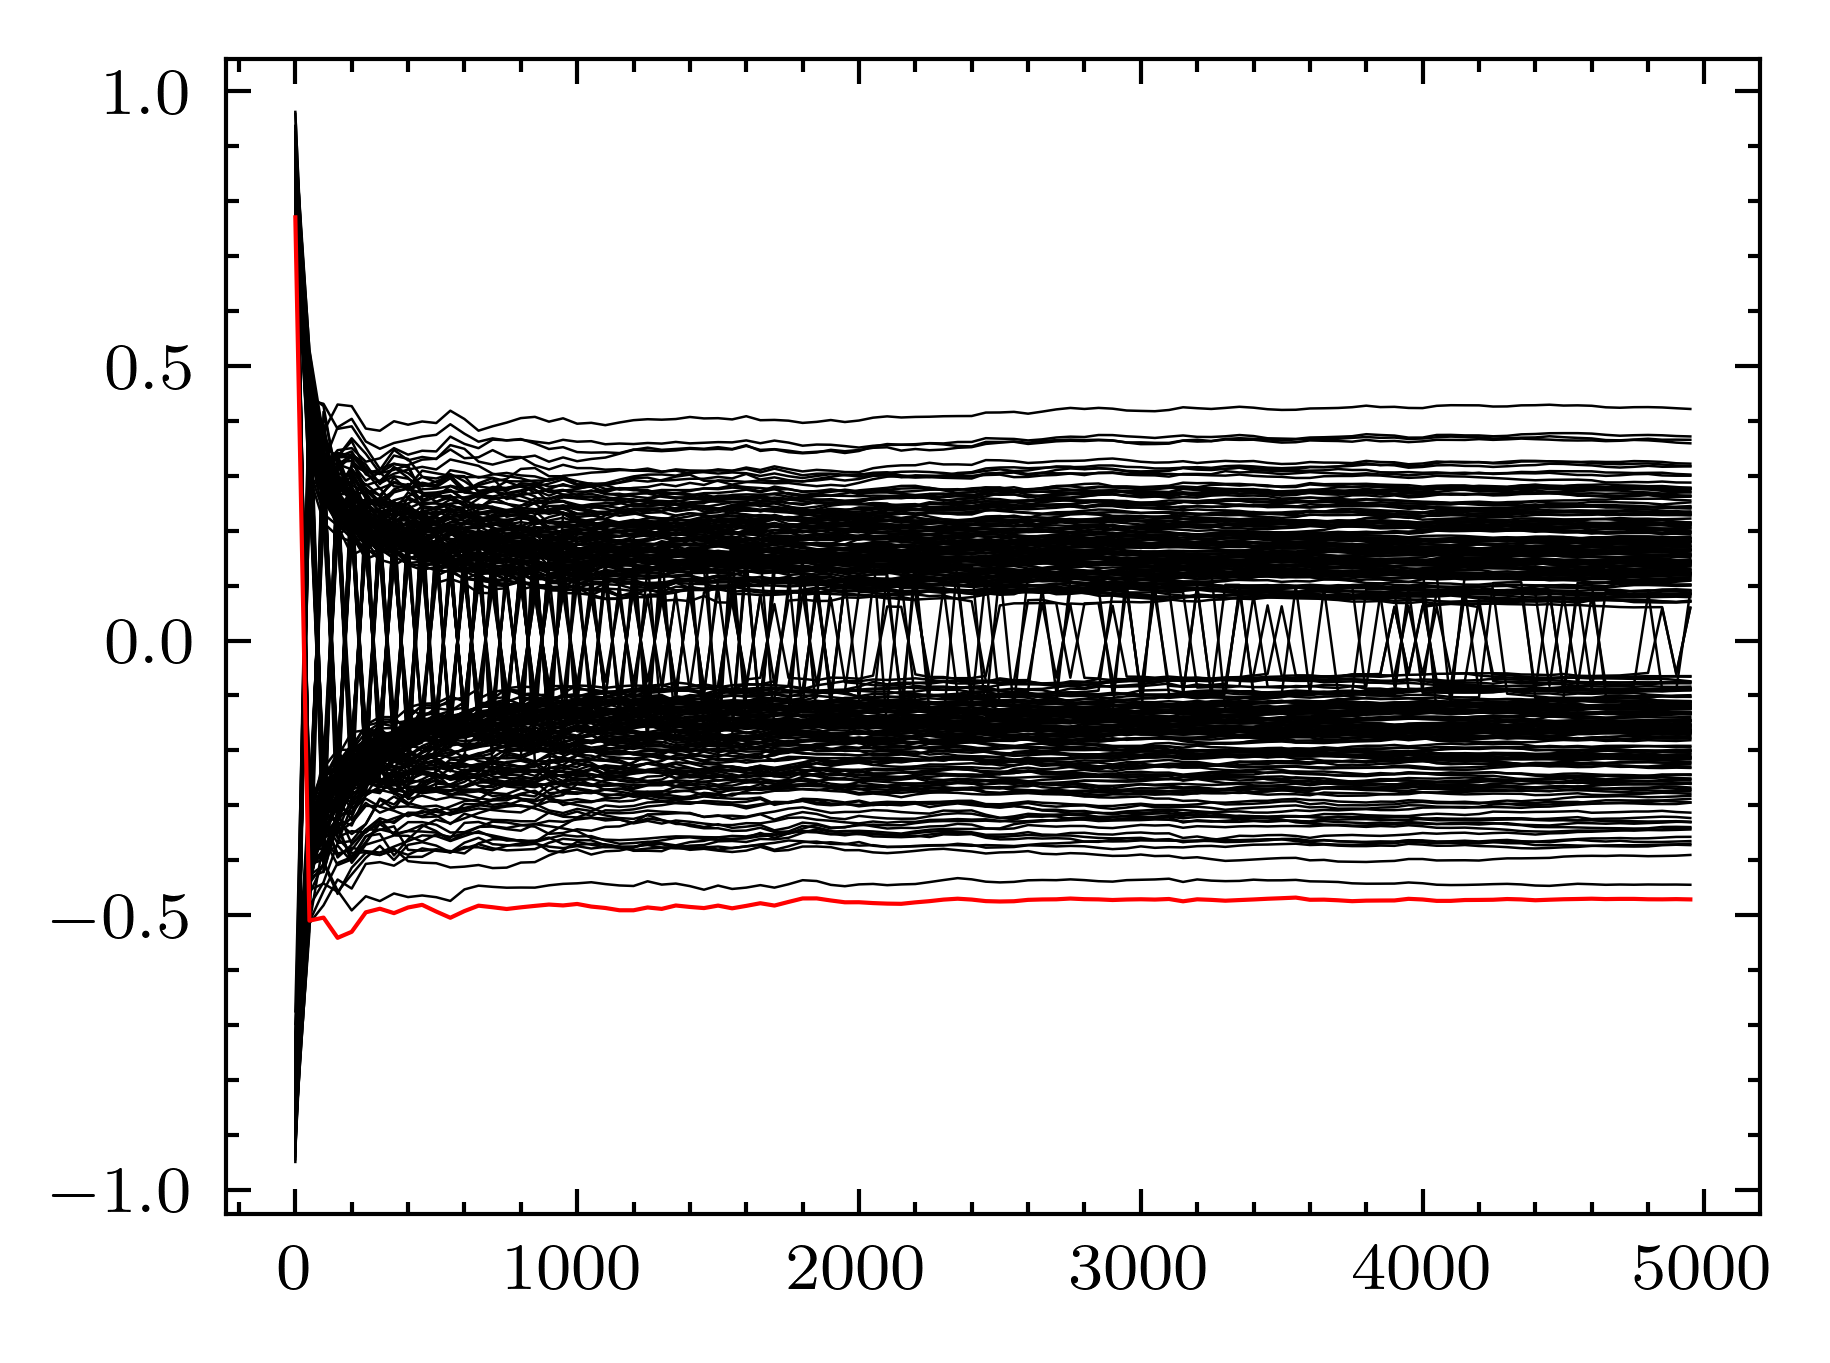

In [6]:
x = np.arange(0, NUM_MEASUREMENTS, step=di)

correct_guess = int(key[3] & KEY_MASK[3])
correct_guess_idx = np.where(guessed_keys[:,3] == correct_guess)[0][0]

with plt.style.context(['science', 'ieee']):
    for i in range(256):
        plt.plot(x, best_corrs_over_num_measurements[i], color="black", linewidth=0.3, linestyle="-")
    plt.plot(x, best_corrs_over_num_measurements[correct_guess_idx], color="red", linewidth=0.5, linestyle="-")
    plt.savefig("diagrams/correlation_over_num_measurements_andgate.pdf")
    plt.savefig("diagrams/correlation_over_num_measurements_andgate.pgf")

In [9]:
print(best_corrs_over_num_measurements[correct_guess_idx][-1])

inverted_guess =  ~correct_guess & KEY_MASK[3]
inverted_guess_idx = np.where(guessed_keys[:,3] == inverted_guess)[0][0]

print(best_corrs_over_num_measurements[inverted_guess_idx][-1])

-0.4712909252418975
0.421616457739811
